<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/%5BFT%5DViT_Baseline_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Mar 27 21:34:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"tingsongou","key":"f6cc12e409af2aa8bdf85bca88a3d434"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

# 1. Start

https://github.com/poloclub/diffusiondb \\
https://www.kaggle.com/code/shoheiazuma/diffusiondb-data-cleansing \\
https://www.kaggle.com/code/shoheiazuma/stable-diffusion-vit-baseline-train \\
https://www.kaggle.com/code/shoheiazuma/stable-diffusion-vit-baseline-inference

In [2]:
!pip install -q sentence-transformers datasets tqdm timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 15.2 MB/s eta 0:

In [3]:
import numpy as np
from scipy import spatial

import datasets
from tqdm.notebook import tqdm
import timm
from timm.utils import AverageMeter

import os
import unicodedata
import pandas as pd
from sentence_transformers import SentenceTransformer

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [32]:
class Config():
    model_name = "vit_base_patch16_224"
    input_size = 224
    batch_size = 256
    num_epochs = 100
    lr = 1e-4

In [7]:
data = datasets.load_dataset('poloclub/diffusiondb', 'large_random_50k', split="train") # 5k data takes about 3.3G

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusiondb downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusiondb/large_random_50k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


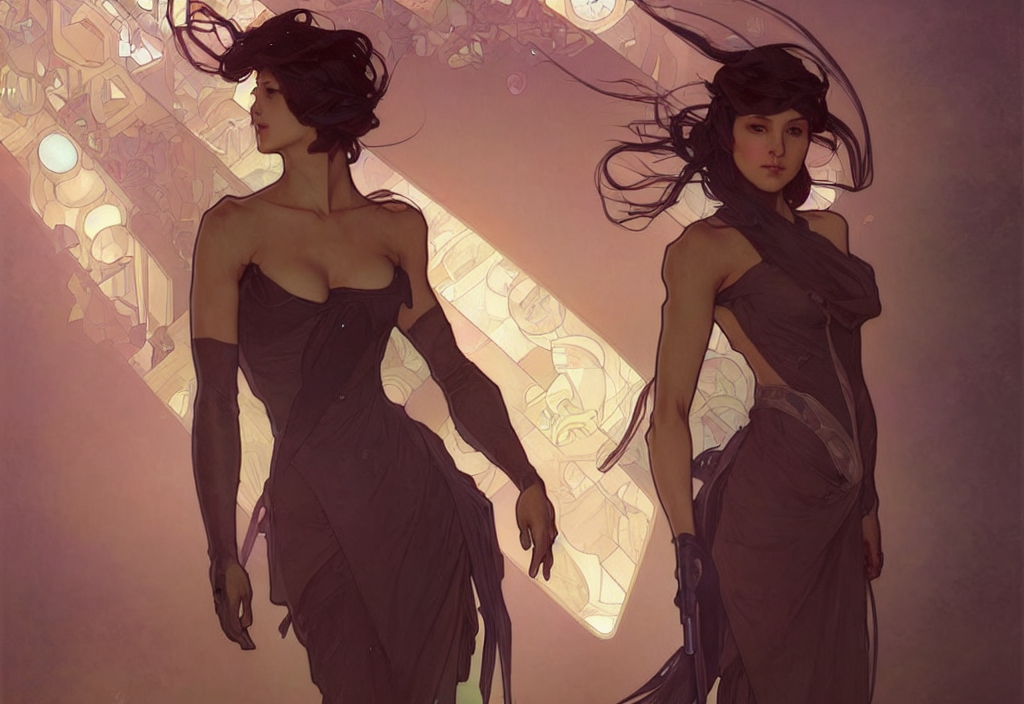

a digital concept ar by artgerm and greg rutkowski and alphonse mucha. full body!! t pose!! clear portrait of a lonely attractive people in uniform!! future military, sci - fi weapon, light effect. hyper detailed, character concept, glowing lights!! intricate, elegant, digital painting, artstation, smooth, sharp focus 


In [25]:
num_data = len(data)
display(data[3]["image"])
print(data[3]["prompt"])

In [33]:
class DiffusionDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        self.length = len(self.data)

    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        image, prompt = self.data[i]["image"], self.data[i]["prompt"]
        image = self.transform(image)
        return image, prompt


class DiffusionCollator():
    def __init__(self):
        self.st_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2',
                                            device="cpu")
    
    def __call__(self, batch):
        images, prompts = zip(*batch)
        images = torch.stack(images)
        prompt_embs = self.st_model.encode(
            prompts,
            show_progress_bar=False,
            convert_to_tensor = True
        )

        return images, prompt_embs

In [34]:
def get_dataloaders(train_split, valid_split, input_size, batch_size):

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.CenterCrop(input_size),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    train_dataset = DiffusionDataset(train_split, transform)
    valid_dataset = DiffusionDataset(valid_split, transform)
    collate_fn = DiffusionCollator()

    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True,
                              collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              pin_memory=True,
                              collate_fn=collate_fn)
    
    return train_loader, valid_loader

In [28]:
# train_split, valid_split = random_split(data, [int(num_data * 0.7), int(num_data * 0.3)])
# train_loader, valid_loader = get_dataloaders(train_split, valid_split, 224, 32)

In [29]:
def cosine_similarity(y_trues, y_preds):
    return np.mean([
        1 - spatial.distance.cosine(y_true, y_pred)
        for y_true, y_pred in zip(y_trues, y_preds)
    ])

In [35]:
def train(train_split, valid_split, model_name, input_size, batch_size, num_epochs, lr):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training device: {device}")

    train_loader, valid_loader = get_dataloaders(train_split, valid_split, input_size, batch_size)
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=384
    )

    model.set_grad_checkpointing()
    model.to(device)

    total_iters = num_epochs * len(train_loader)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
    criterion = torch.nn.CosineEmbeddingLoss()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_iters, eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler()

    best_score = -1.0

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()

        train_meters = {
            "loss": AverageMeter(),
            "cos": AverageMeter()
        }

        model.train()

        for X, y in tqdm(train_loader, leave=False):
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            X_out = model(X)
            target = torch.ones(X.shape[0]).to(device)
            loss = criterion(X_out, y, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            train_loss = loss.item()
            train_cos = cosine_similarity(
                X_out.detach().cpu().numpy(),
                y.detach().cpu().numpy()
            )

            train_meters["loss"].update(train_loss, n=X.shape[0])
            train_meters["cos"].update(train_cos, n=X.shape[0])

        valid_meters = {
            "loss": AverageMeter(),
            "cos": AverageMeter()
        }

        print("Epoch {:d}\n\t train loss={:.4f}, train cos={:.4f}".format(
            epoch + 1,
            train_meters["loss"].avg,
            train_meters["cos"].avg))


        model.eval()
        for X, y in tqdm(valid_loader, leave=False):
            X, y = X.to(device), y.to(device)

            with torch.no_grad():
                X_out = model(X)
                target = torch.ones(X_out.shape[0]).to(device)
                loss = criterion(X_out, y, target)

                val_loss = loss.item()
                val_cos = cosine_similarity(
                    X_out.detach().cpu().numpy(),
                    y.detach().cpu().numpy()
                )
            
            valid_meters["loss"].update(val_loss, n=X.shape[0])
            valid_meters["cos"].update(val_cos, n=X.shape[0])

        print("\t val loss={:.4f}, val cos={:.4f}".format(
            epoch + 1,
            valid_meters["loss"].avg,
            valid_meters["cos"].avg))

        if valid_meters["cos"].avg > best_score:
            best_score = valid_meters["cos"].avg
            torch.save(model.state_dict(), f"/content/drive/MyDrive/saved_models/{model_name}.pth")
        
        del X, y

In [36]:
train_split, valid_split = random_split(data, [int(num_data * 0.8), int(num_data * 0.2)])
train(train_split, valid_split,
      Config.model_name,
      Config.input_size,
      Config.batch_size,
      Config.num_epochs,
      Config.lr)

Training device: cuda


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: ignored